(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg BayesFitness

import Revise
# Import project package
import BayesFitness
# Import library to list files
import Glob
# Import package to save chains into memory
import JLD2

# Import package to handle DataFrames
import DataFrames as DF
import CSV

# Import basic statistical functions
import Distributions
import StatsBase
import Random

# Import basic math
import LinearAlgebra

# Import libraries relevant for MCMC
import Turing
import MCMCChains

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
import Makie
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
BayesFitness.viz.pboc_makie!()

# Inferred fitness exploratory data analysis

Having established the pipeline to analyze the barcode trajectories and infer a
fitness value, let's explore the resulting outcomes. The first thing we need to
do is list the files with the MCMC chains for all mutants.

In [28]:
# List MCMC chain files
files = Glob.glob(
    "$(git_root())/code/processing/mcmc_bigbatch_mutantfitness/"[2:end] *
    "output/2000steps_4walkers/*jld2",
    "/"
)

# Initialize data frame to store file metadata
df_files = DF.DataFrame()

# Loop through files
for file in files
    # Split name
    file_split = split(split(file, "/")[end], "_")
    # Extract information
    batch = file_split[1]
    hub = replace(file_split[2], "hub" => "")
    perturbation = replace(file_split[3], "perturbation" => "")
    rep = replace(file_split[4], "rep" => "")

    # Add information to dataframe
    DF.append!(
        df_files,
        DF.DataFrame(
            batch = batch,
            hub = hub,
            perturbation = perturbation,
            rep = rep,
            file = file
        )
    )
end # for

first(df_files, 5)

Row,batch,hub,perturbation,rep,file
,SubStrin…,String,String,String,String
1,Batch2,1Day,1.5,R1,/Users/mrazo/git/bayesian_fitness/code/processing/mcmc_bigbatch_mutantfitness/output/2000steps_4walkers/Batch2_1Dayhub_1.5perturbation_R1rep_mutantfitness_mcmcchains.jld2
2,Batch2,1Day,1.5,R2,/Users/mrazo/git/bayesian_fitness/code/processing/mcmc_bigbatch_mutantfitness/output/2000steps_4walkers/Batch2_1Dayhub_1.5perturbation_R2rep_mutantfitness_mcmcchains.jld2


Before looking at the inference. Let's load the raw counts data and add the
naive frequencies for each barcode.

In [141]:
# Load data
df = CSV.read("$(git_root())/data/big_batch/tidy_counts.csv", DF.DataFrame)

# Use the split-apply-combine strategy to compute total counts for each
# experiment.
count_sum = DF.combine(
    DF.groupby(df, [:batch, :hub, :perturbation, :timepoint]), :count => sum
)
# Add count sum to dataframe
DF.leftjoin!(df, count_sum, on=[:batch, :hub, :perturbation, :timepoint])

# Add naive frequency estimate
df[!, :freq] = df.count ./ df.count_sum

first(df, 5)

Row,BCID_x,bc_merged,barcode,barcode_lowcomplexity,barcode_highcomplexity,BCID_y,barcode_fasta,source_publication,cloneID,cloneID_new,evolution_condition,ancestor,class,ploidy,ploidy_new,gene,type,additional_muts,1D_Fitness_Li2019,1D_Error_Li2019,2D_Fitness_Li2019,2D_Error_Li2019,3D_Fitness_Li2019,3D_Error_Li2019,5D_Fitness_Li2019,5D_Error_Li2019,FerPerHour_Li2019,ResPerHour_Li2019,StaPerHour_Li2019,name,count,rep,timepoint,time,batch,hub,perturbation,neutral,count_sum,freq
,Int64,String,String,String31,String,Int64,String,String15,String31,String?,String7,String15,String31,String15,String15,String31,String?,String?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String,Int64,String3,String3,Int64,String7,String7,String31,Bool,Int64?,Float64
1,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,TGATCAATCTACAAAAATATTTAATG,GAGTGAAACATGAATGGTATTCATCA,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,This_study,missing,EVO2D_IRA1_MIS_rearray_Plate1-A1,Evo2D,IRA1_MIS,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,53,R1,T0,0,Batch1,1Day,28,false,1087894,4.8718e-5
2,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT,CCGCCAATCCCGAACCCCGTTTCGCC,ACTCTAACGTGTAACTAATTTTGAGT,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,Aggeli2020,gpb2_evo1_plate9_H8,gpb2_evo1_plate9_H8,Evo2D,GPB2,adaptive_haploids,Haploid,Haploid,missing,Other,DOP1-NON_SYNONYMOUS_CODING; SMD2-NON_SYNONYMOUS_CODING; YDL180W-DOWNSTREAM; LAS21-UPSTREAM,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,1213,R1,T0,0,Batch1,1Day,28,false,1087894,0.001115
3,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,GACAGAAAAGCCAAATGGATTTACCG_ATGGGAACACGGAATGATCTTTTATT,GACAGAAAAGCCAAATGGATTTACCG,ATGGGAACACGGAATGATCTTTTATT,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,This_study,missing,EVO3D_TCG_rearray_Plate1-A4,Evo3D,CYR1,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,17,R1,T0,0,Batch1,1Day,28,false,1087894,1.56265e-5
4,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,CCAACAAAACACAAATCTGTTGTGTA_TACTAAATAAGTAAGGGAATTCTGTT,CCAACAAAACACAAATCTGTTGTGTA,TACTAAATAAGTAAGGGAATTCTGTT,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,This_study,missing,EVO2D_IRA1_NON_rearray_Plate1-A1,Evo2D,IRA1_NON,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,19,R1,T0,0,Batch1,1Day,28,false,1087894,1.74649e-5
5,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG,TATCGAAACCCAAAGAGATTTAATCG,ATGACAAACTTTAAATAATTTAATTG,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,This_study,missing,EVO3D_IRA1_MIS_rearray_Plate1-C4,Evo3D,IRA1_MIS,missing,missing,haploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,23,R1,T0,0,Batch1,1Day,28,false,1087894,2.11418e-5


Let's plot a few of the distributions for randomly selected mutants to make sure
they look okay.

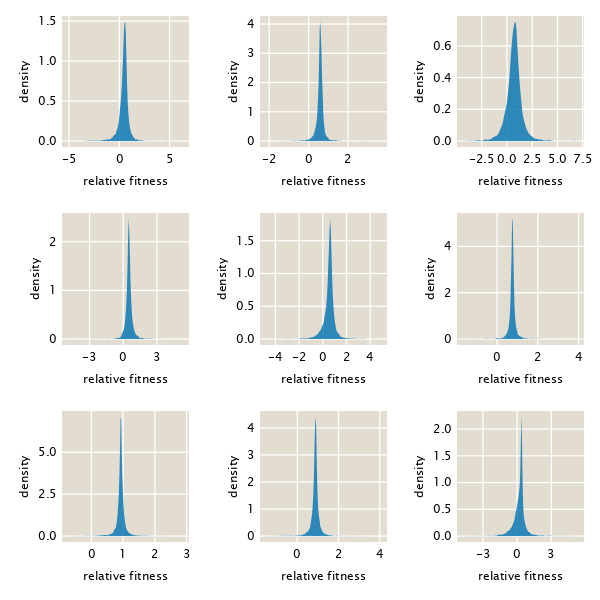

In [122]:
Random.seed!(42)

# Index of file to extract
idx_chain = 1

# Load sample file
chains = JLD2.load(df_files.file[idx_chain])["chains"]
# Collect all keys
chain_keys = collect(keys(chains))

# Initialize figure
fig = Figure(resolution=(600, 600))

# Add axes
axes = [
    Axis(
        fig[i, j],
        xlabel="relative fitness",
        ylabel="density"
    )
    for i=1:3 for j=1:3
]

# Loop through axes
for (i, ax) in enumerate(axes)
    # Add density
    density!(
        ax, 
        vec(Matrix(chains[chain_keys[i+1]][:, Symbol("s⁽ᵐ⁾"), :]))
    )

    # Modify text size
    ax.xlabelsize = 12
    ax.ylabelsize = 12
    ax.xticklabelsize = 12
    ax.yticklabelsize = 12
end # for

fig

Let's look at some of the traces.

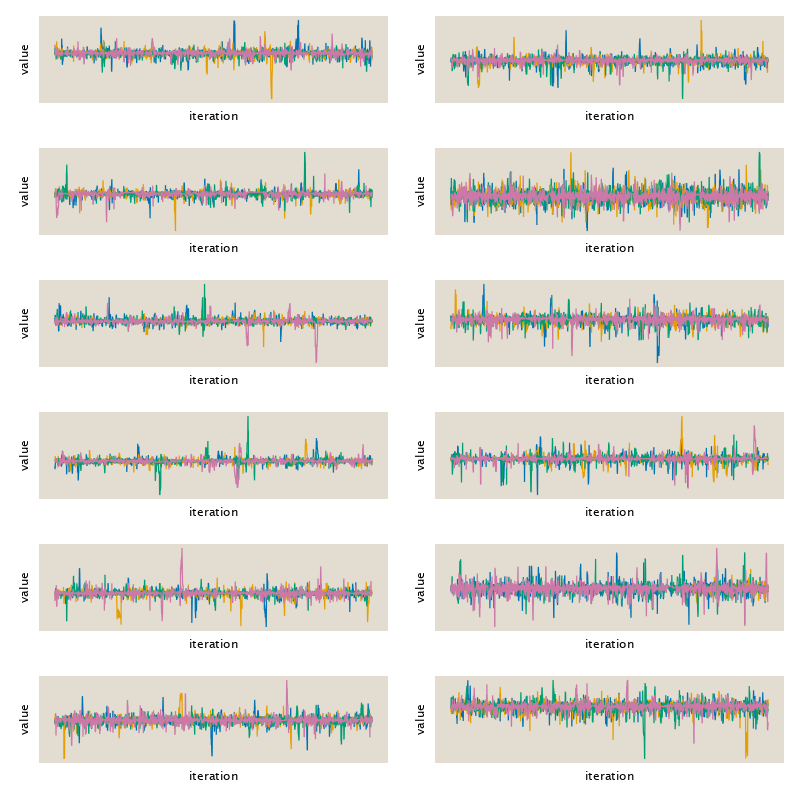

In [123]:
# Initialize figure
fig = Figure(resolution=(800, 800))

# Add axes
axes = [
    Axis(
        fig[i, j],
        xlabel="iteration",
        ylabel="value"
    )
    for i=1:6 for j=1:2
]

# Loop through axes
for (i, ax) in enumerate(axes)
    # Extract chain information
    chain = Matrix(chains[chain_keys[i]][:, Symbol("s⁽ᵐ⁾"), :])
    # Loop through chains
    for trace in eachcol(chain)
        # Add trace
        lines!(
            ax,
            trace
        )
    end # for

    # Modify text size
    ax.xlabelsize = 12
    ax.ylabelsize = 12
    ax.xticklabelsize = 12
    ax.yticklabelsize = 12
    # Hide axis decorations
    hideydecorations!(ax; label=false)
    hidexdecorations!(ax; label=false)
end # for

fig

Let's define a function to compute the posterior predictive checks for the log
ratio of frequencies.

In [108]:
@doc raw"""
    `fitness_mut_ppc(chain, sₘ, sₜ)`
"""
function fitness_mut_ppc( 
    chain::MCMCChains.Chains, 
    s⁽ᵐ⁾::Symbol=Symbol("s⁽ᵐ⁾"), 
    sₜ::Symbol=Symbol("s̲ₜ"),
)
    # Extract number of chains
    n_chains = length(MCMCChains.chains(chain))
    # Extract number of steps per chain
    n_samples = length(chain)
    # Extract number of timepoints
    n_time = size(MCMCChains.group(chain, sₜ), 2)
    # Extract parameter names
    par_names = names(chain, :parameters)

    # Extract relevant parameters
    # 1. Mutant fitness
    s⁽ᵐ⁾_chain = MCMCChains.get(chain, s⁽ᵐ⁾)[1]
    # 2. Population mean fitness chain. This is collected into a Tensor where
    #    each face are the samples corresponding to a time point.
    sₜ_chain = cat(
        collect(
            MCMCChains.get(chain, MCMCChains.namesingroup(chain, sₜ))
            )...; 
            dims=3
    )

    # Compute posterior predictive checks
    return s⁽ᵐ⁾_chain .- sₜ_chain
end # function

fitness_mut_ppc

Let's test the function on a single barcode. For this, we need to extract the
raw data to compare it.

In [155]:
# Select barcode to use
bc = chain_keys[1]

# Extract chain
chain = chains[bc]

# Compute posterior predictive checks for a particular chain
logγ_ppc = fitness_mut_ppc(chain)
# Compact multiple chains into single long chain
logγ_ppc = vcat([logγ_ppc[:, :, i] for i = 1:size(logγ_ppc, 3)]...)

# Extract sample metadata to extract raw counts
batch, hub, perturbation, rep = values(df_files[idx_chain, DF.Not(:file)])

# Extract data
data = df[
    (df.barcode .== collect(bc)) .&
    (df.batch .== batch) .&
    (df.hub .== hub) .&
    (df.perturbation .== perturbation) .&
    (df.rep .== rep),
:]

# Sort by timepoint
DF.sort(data, :time)

# Compute log ratio
logγ = diff(log.(data.freq));

Now, let's plot the log frequency ratios and the posterior predictive checks.

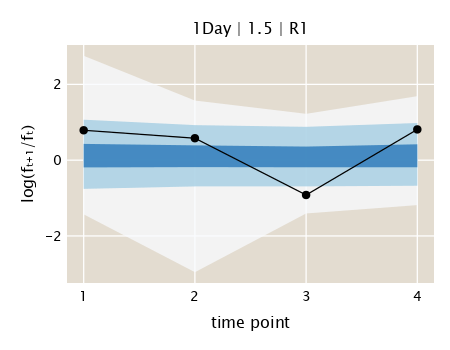

In [187]:
# Define quantiles to compute
qs = [0.995, 0.95, 0.5]

# Initialize matrix to save quantiles
logγ_quant = Array{Float64}(undef, size(logγ_ppc, 2), length(qs), 2)

# Loop through quantile
for (i, q) in enumerate(qs)
    # Lower bound
    logγ_quant[:, i, 1] = StatsBase.quantile.(
        eachcol(logγ_ppc), (1. - q) / 2.
    )
    # Upper bound
    logγ_quant[:, i, 2] = StatsBase.quantile.(
        eachcol(logγ_ppc), 1. - (1. - q) / 2.
    )
end # for

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log(fₜ₊₁/fₜ)",
    title="$(hub) | $(perturbation) | $(rep)"
)

# Define colors
colors = get(ColorSchemes.Blues_9, LinRange(0, 0.75, 3))

# Loop through quantiles
for i in eachindex(qs)
    # Add confidence interval for observation
    band!(
        ax,
        1:size(logγ_ppc, 2),
        # zeros(size(logγ_ppc, 2)),
        # ones(size(logγ_ppc, 2)),
        logγ_quant[:, i, 1],
        logγ_quant[:, i, 2],
        color=(colors[i], 0.75)
    )
end # for



# Plot trajectory
scatterlines!(ax, logγ, color=:black)


fig